# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np 
import cv2
import PIL
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import glob
import random
import os
from os import listdir
random.seed(100)
np.random.seed(100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


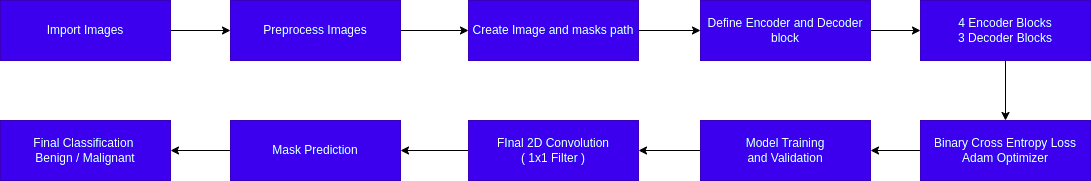

## Creating image paths and mask paths

In the csv files, we have the file paths. We need to first change that to follow correct kaggle paths.
Finally, we need a list of image paths and roi mask paths.

In [2]:
dicom_data = pd.read_csv('../input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [3]:
image_dir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path

cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path

roi_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

full_mammogram_images.iloc[0]


'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'

In [4]:
full_mammogram_dict = dict()
cropped_dict = dict()
roi_mask_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[4]
    full_mammogram_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_dict[key] = dicom
for dicom in roi_mask_images:
    key = dicom.split("/")[4]
    roi_mask_dict[key] = dicom
    
next(iter((full_mammogram_dict.items())) )

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [5]:
mass_train_data = pd.read_csv('../input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')

mass_test_data = pd.read_csv('../input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

In [6]:
mass_test_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [7]:
mass_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [8]:
mass_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               378 non-null    object
 1   breast_density           378 non-null    int64 
 2   left or right breast     378 non-null    object
 3   image view               378 non-null    object
 4   abnormality id           378 non-null    int64 
 5   abnormality type         378 non-null    object
 6   mass shape               378 non-null    object
 7   mass margins             361 non-null    object
 8   assessment               378 non-null    int64 
 9   pathology                378 non-null    object
 10  subtlety                 378 non-null    int64 
 11  image file path          378 non-null    object
 12  cropped image file path  378 non-null    object
 13  ROI mask file path       378 non-null    object
dtypes: int64(4), object(10)
memory usage: 41.5

In [9]:
def fix_image_path(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        dataset.iloc[i,11] = full_mammogram_dict[img_name]
        img_name = img[12].split("/")[2]
        dataset.iloc[i,12] = cropped_dict[img_name]
        img_name = img[13].split("/")[2]
        dataset.iloc[i,13] = roi_mask_dict[img_name]

In [10]:
fix_image_path(mass_train_data)
fix_image_path(mass_test_data)

In [11]:
mass_train_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [12]:
mass_data = pd.concat((mass_train_data,mass_test_data))

In [13]:
mass_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1696 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1696 non-null   object
 1   breast_density           1696 non-null   int64 
 2   left or right breast     1696 non-null   object
 3   image view               1696 non-null   object
 4   abnormality id           1696 non-null   int64 
 5   abnormality type         1696 non-null   object
 6   mass shape               1692 non-null   object
 7   mass margins             1636 non-null   object
 8   assessment               1696 non-null   int64 
 9   pathology                1696 non-null   object
 10  subtlety                 1696 non-null   int64 
 11  image file path          1696 non-null   object
 12  cropped image file path  1696 non-null   object
 13  ROI mask file path       1696 non-null   object
dtypes: int64(4), object(10)
memory usage: 198.8+ K

## Visualizing the Image and Mask

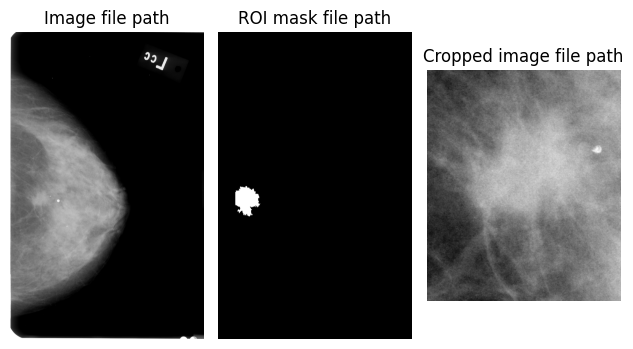

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the image file
img_full = mpimg.imread(mass_data.iloc[0]['image file path'])
img_full_cv2 = cv2.imread(mass_data.iloc[0]['image file path'], cv2.IMREAD_COLOR)


img_crop = mpimg.imread(mass_data.iloc[0]['cropped image file path'])
img_roi = mpimg.imread(mass_data.iloc[0]['ROI mask file path'])
    
# Plot the image
fig, axs = plt.subplots(1, 3)
axs[0].imshow(img_full, cmap='gray')
axs[1].imshow(img_roi, cmap='gray')
axs[2].imshow(img_crop, cmap='gray')

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

axs[0].set_title('Image file path')
axs[1].set_title('ROI mask file path')
axs[2].set_title('Cropped image file path')

plt.tight_layout()

# Show the plot
plt.show()
mass_data.head(1)

In [15]:
image_paths = mass_data['image file path']
mask_paths = mass_data['ROI mask file path']

# Model Building

In [16]:
# import system libs 
import os
import time
import glob
import shutil

# import data handling tools 
import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import TensorBoard

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## Loading the images

In [17]:
# function to read an image
def load_single_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# function to read multiple images
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i, image in tqdm_notebook(enumerate(image_paths), desc= 'Progress bar'):
        img = load_single_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    
    return images

# Visualising the mask overlayed on the image

In [18]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

def show_images(imgs, msks):
    plt.figure(figsize=(13,8))
    
    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')
    
    plt.tight_layout()
    plt.show()

In [19]:
from tqdm.notebook import tqdm_notebook
import time

In [20]:
SIZE = 128

# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)


Progress bar: 0it [00:00, ?it/s]

Progress bar: 0it [00:00, ?it/s]

# Creating the Encoder and Decoder Blocks 

## Encoder
- The Encoder’s purpose is to extract high-level features from the input image by reducing its size and increasing the number of features.
- The input is a grayscale image of size 1024x1024 pixels.
- The image goes through a series of convolutional layers. In the beginning, 32 filters are applied, leading to an output with 32 channels. Next, convolutional layers with 64 filters are used, resulting in an output with 64 channels.
- Max Pooling is applied to downsample the image, reducing its size. This helps capture global context and important high-level features.


In [21]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, encoder = False,**kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        if encoder:
            self.filter2= 2*filters
        else:
            self.filter2 = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(self.filter2, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

## Decoder
- The Decoder’s goal is to restore the original image’s spatial resolution (1024x1024) while reducing the number of channels.
- Each upsampling layer in the Decoder is connected with the corresponding layer in the Encoder using a skip connection. This helps combine local and global features for accurate predictions
- The image from the Encoder is passed through transposed convolutional layers to increase its size (upsampling). This ensures that the segmentation map matches the original image’s dimensions
- A 1x1 convolutional layer is then applied to reduce the number of channels while retaining crucial information. The final output has three channels, each representing the probability of “normal”, “benign” and “malignant"

In [22]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)
    
    
    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [23]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0
        
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:}  -   accuracy=  {2:5.3f}   -   loss: {3:8.5f}'.format(' ', str(batch),  acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        print('\n')
        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{duration:^8.2f}'
        print(msg)

        if self.ask_epoch != None and self.ask_permission != 0:
            if epoch + 1 >= self.ask_epoch:
                msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                print(msg)
                ans = input('')
                if ans == 'H' or ans == 'h':
                    msg = f'training has been halted at epoch {epoch + 1} due to user input'
                    print(msg)
                    self.model.stop_training = True # stop training
                else:
                    try:
                        ans = int(ans)
                        self.ask_epoch += ans
                        msg = f' training will continue until epoch ' + str(self.ask_epoch)
                        print(msg)
                        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'Duration')
                        print(msg)
                    except:
                        print('Invalid')

In [24]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

# Creating the model

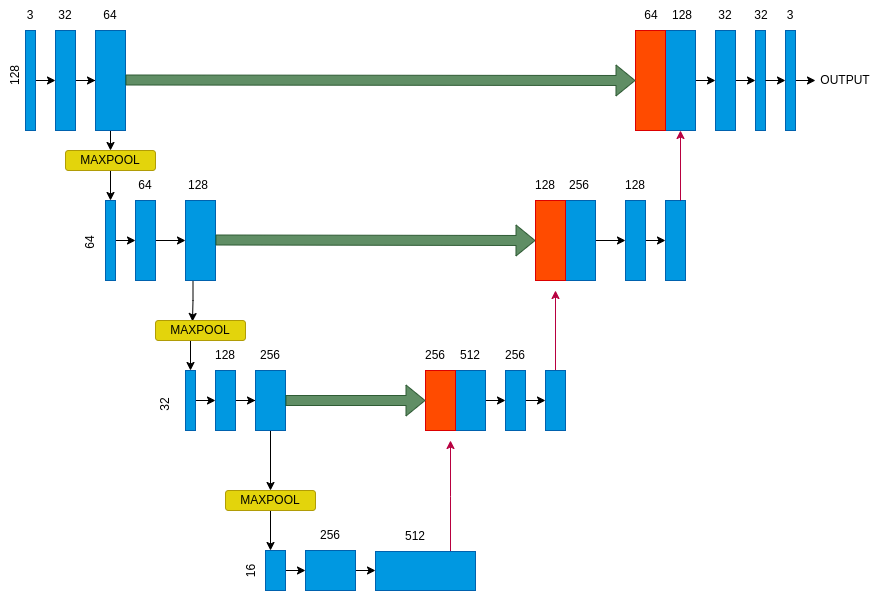

In [25]:
input_layer = Input(shape= imgs.shape[-3:])

p1,c1 = EncoderBlock(32,0.1, name = "Encoder1", encoder = True)(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2", encoder = True)(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3", encoder = True)(p2)

encoding = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p3)

d1 = DecoderBlock(512,0.2,name="Decoder1")([encoding,c3])
d2 = DecoderBlock(256,0.1,name = "Decoder2")([d1,c2])
d3 = DecoderBlock(128,0.1,name = "Decoder3")([d2,c1])

output_layer = Conv2D(1, kernel_size = 1, activation = 'sigmoid',padding='same')(d3)

model = Model(inputs = [input_layer],outputs = [output_layer])

In [26]:
def dice_coeff(y_true, y_pred):
    smooth = 100
    # Flatten
    y_true_f = tf.cast(tf.reshape(y_true, [-1]),'float32')
    y_pred_f = tf.cast(tf.reshape(y_pred > 0.5, [-1]),'float32')

    intersection = tf.reduce_sum(tf.math.multiply(y_true_f,y_pred_f))
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [27]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

In [28]:
dice_loss = DiceLoss(smooth=1, gama=2)

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (EncoderBlock)        ((None, 64, 64, 64)  19392       ['input_1[0][0]']                
                                , (None, 128, 128,                                                
                                64))                                                              
                                                                                                  
 Encoder2 (EncoderBlock)        ((None, 32, 32, 128  110784      ['Encoder1[0][0]']           

In [31]:
batch_size = 40     # set batch size for training
epochs = 10         # number of all epochs in training
ask_epoch = 5    # number of epochs to run before asking if you want to halt training



callbacks = [MyCallback(model= model, epochs= epochs, ask_epoch= ask_epoch )]

In [32]:
# Config Training
SPE = len(imgs)//batch_size

# Training
history = model.fit(
    imgs, msks,
    validation_split=0.2,
    epochs=40,
    verbose=1,
)

Epoch 1/40
43/43 [==============================] - 81s 1s/step - loss: 1.4565 - accuracy: 0.9938 - val_loss: 0.0368 - val_accuracy: 0.9946
Epoch 2/40
43/43 [==============================] - 32s 743ms/step - loss: 0.0289 - accuracy: 0.9944 - val_loss: 0.0249 - val_accuracy: 0.9946
Epoch 3/40
43/43 [==============================] - 32s 753ms/step - loss: 0.0238 - accuracy: 0.9944 - val_loss: 0.0216 - val_accuracy: 0.9946
Epoch 4/40
43/43 [==============================] - 32s 748ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 0.0197 - val_accuracy: 0.9946
Epoch 5/40
43/43 [==============================] - 32s 750ms/step - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.0210 - val_accuracy: 0.9946
Epoch 6/40
43/43 [==============================] - 32s 750ms/step - loss: 0.0201 - accuracy: 0.9945 - val_loss: 0.0196 - val_accuracy: 0.9946
Epoch 7/40
43/43 [==============================] - 32s 745ms/step - loss: 0.0196 - accuracy: 0.9945 - val_loss: 0.0193 - val_accuracy: 0.9946
Ep

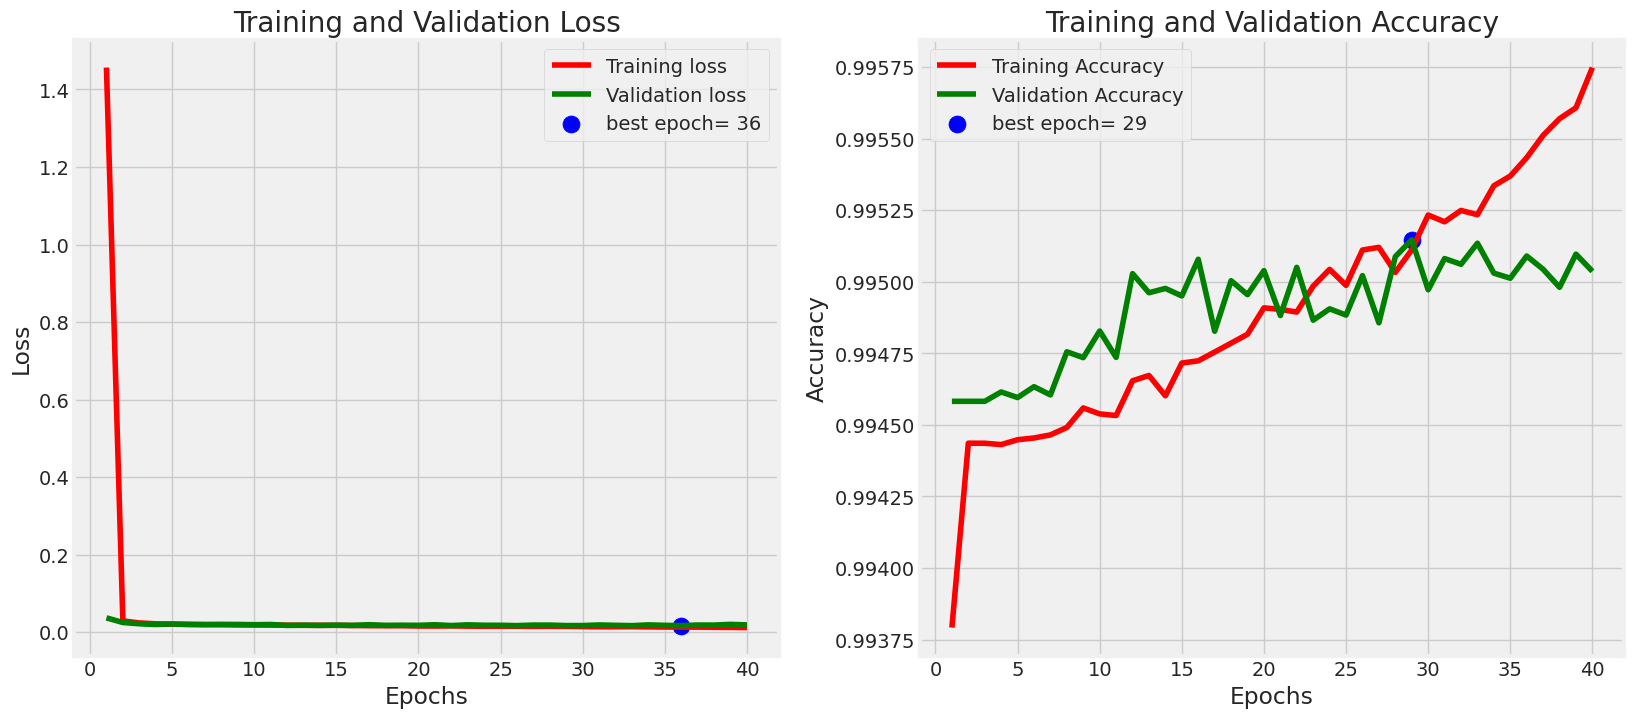

In [33]:
plot_training(history)


1/1 [==============================] - 0s 42ms/step


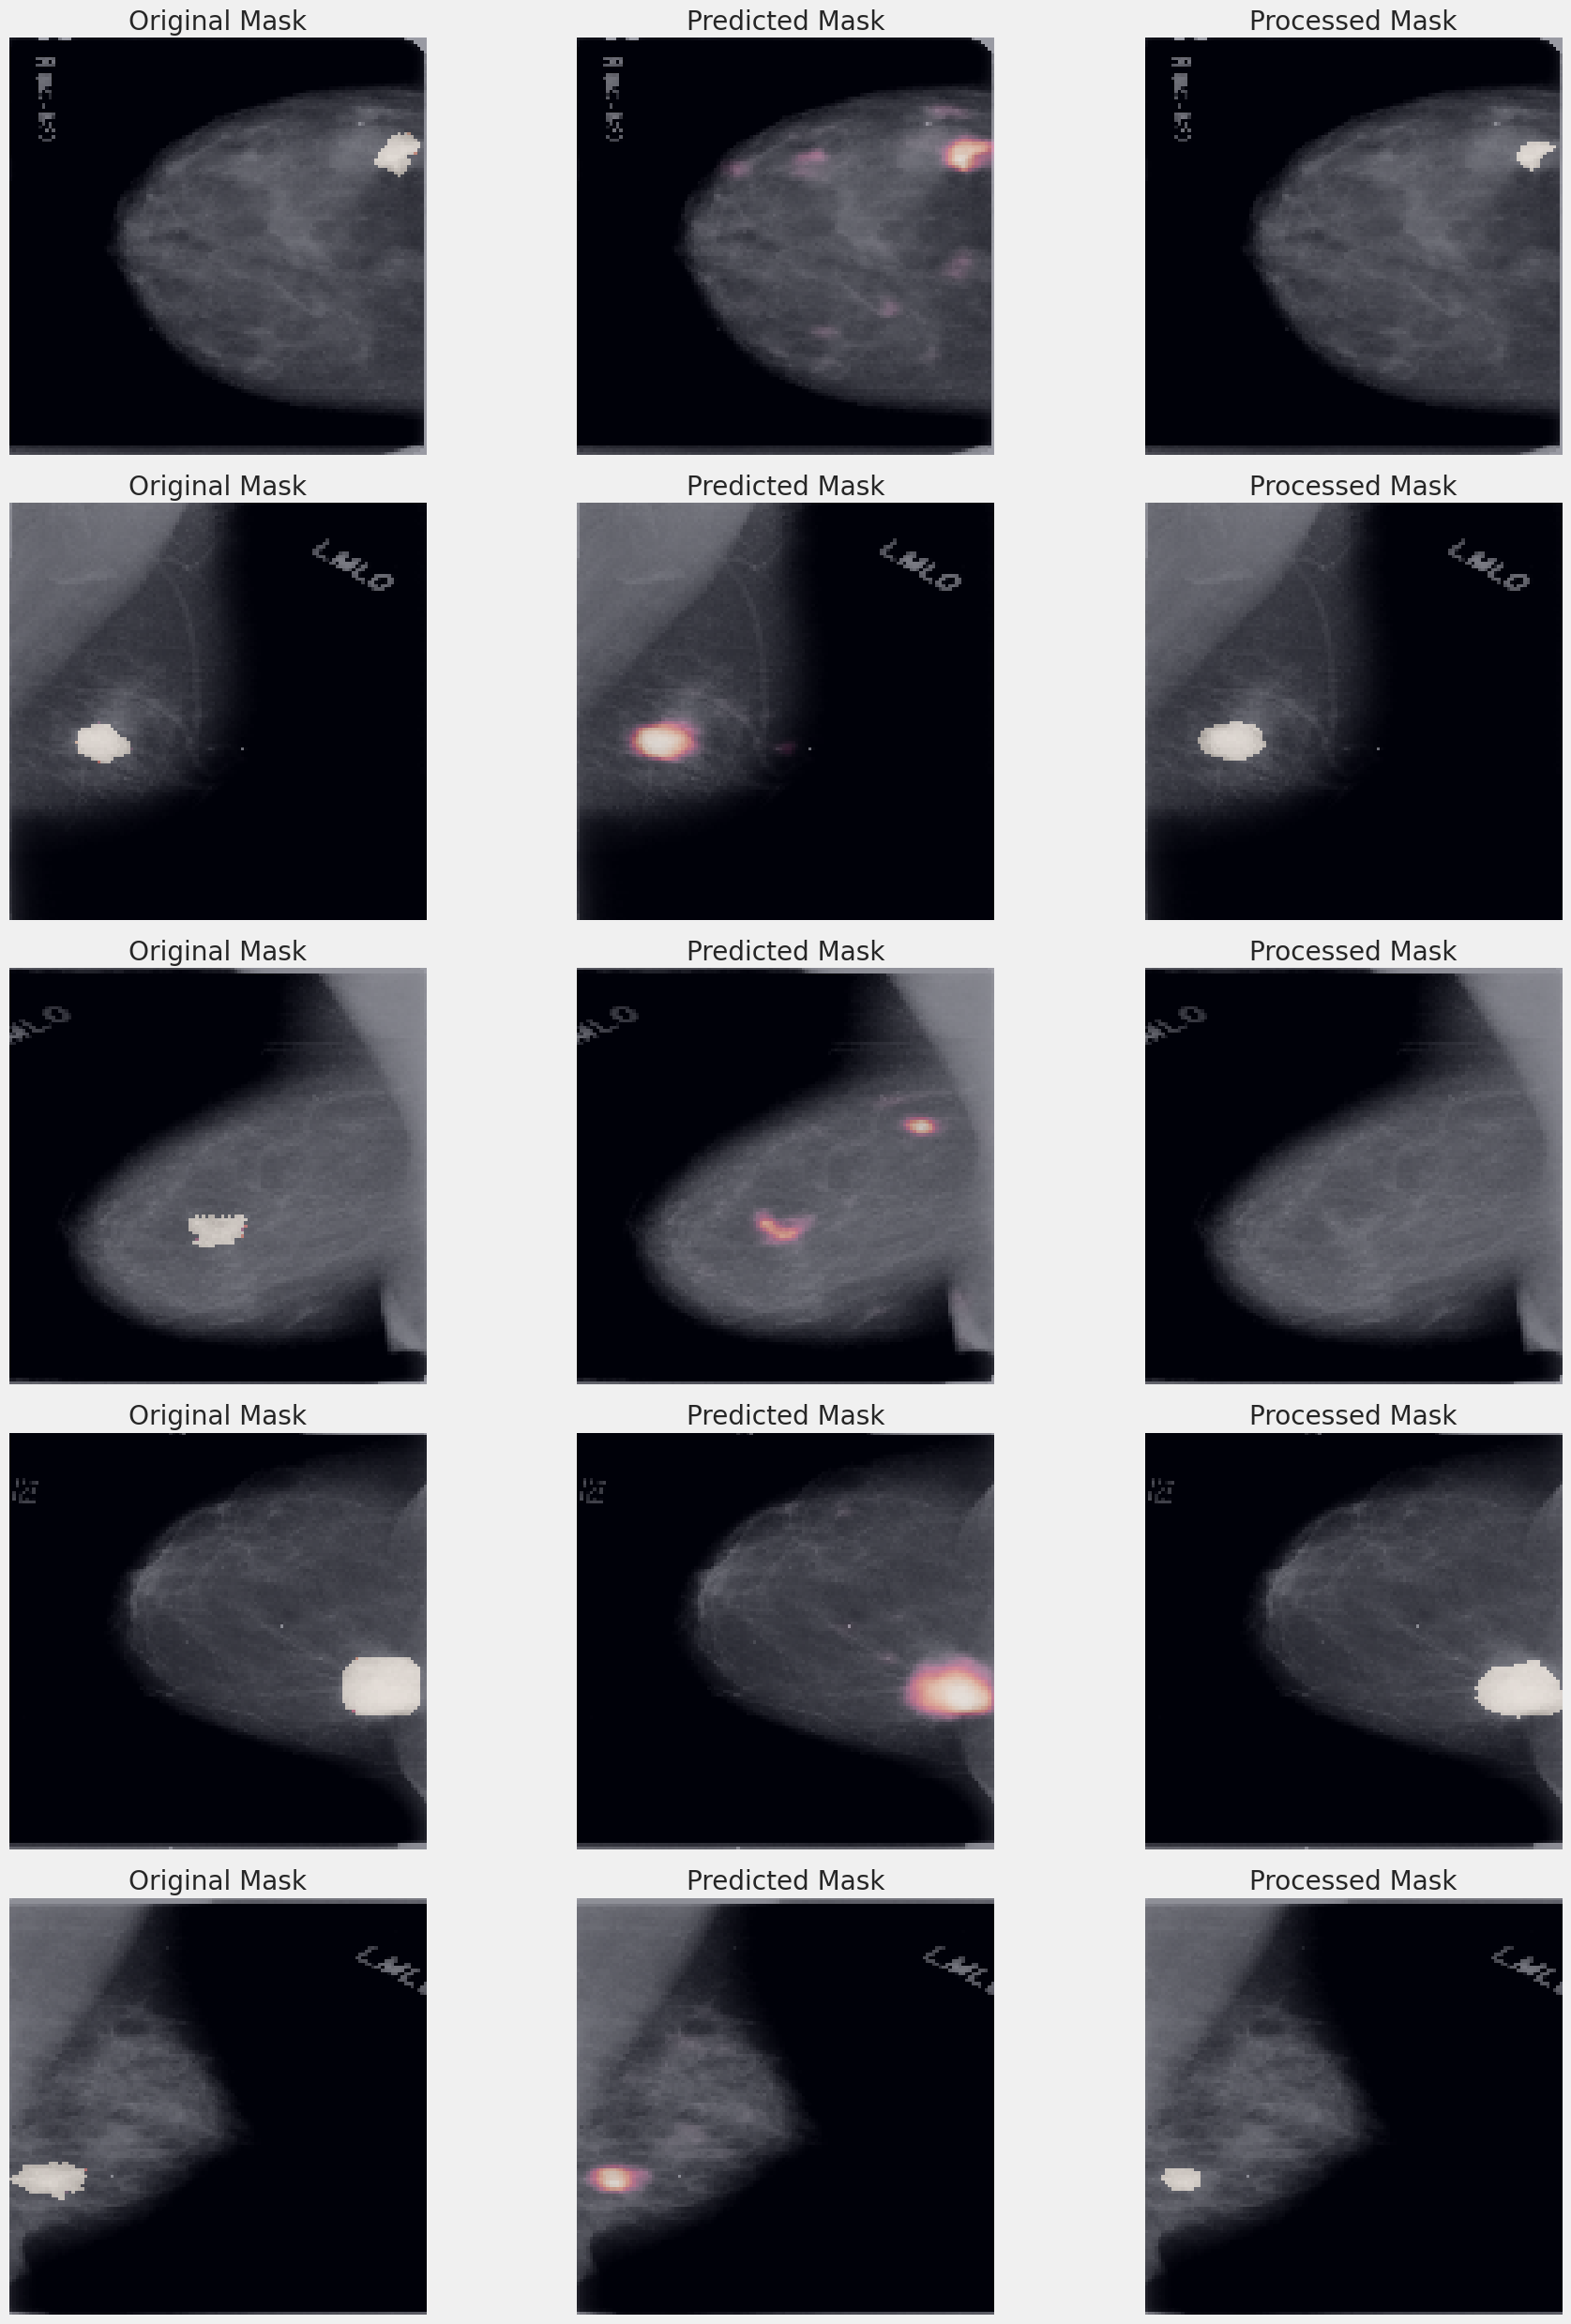

In [50]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(imgs))
        image = imgs[id]
        mask = msks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>=0.3).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [35]:
model.save('sep18th_2:36_model.h5')

In [38]:
id = np.random.randint(len(imgs))
image = imgs[id] 
mask = msks[id]
pred_mask = model.predict(image[np.newaxis,...])

1/1 [==============================] - 0s 42ms/step


In [39]:
pred_mask

array([[[[1.16320727e-04],
         [2.49411983e-06],
         [1.03832110e-06],
         ...,
         [1.45936589e-04],
         [2.83276138e-04],
         [7.13212532e-04]],

        [[6.65629898e-07],
         [2.88664803e-09],
         [1.47813994e-09],
         ...,
         [3.58930947e-06],
         [4.70899977e-06],
         [1.32677023e-05]],

        [[5.43028484e-08],
         [3.08206988e-10],
         [3.31100869e-10],
         ...,
         [1.08929996e-07],
         [3.29249055e-08],
         [2.54142236e-07]],

        ...,

        [[1.81071727e-08],
         [4.30552483e-09],
         [2.94805620e-08],
         ...,
         [4.44199650e-05],
         [1.66402442e-05],
         [1.06556608e-05]],

        [[4.95430356e-07],
         [2.05256754e-07],
         [2.84049037e-07],
         ...,
         [2.09749342e-05],
         [5.39759912e-06],
         [1.25222550e-05]],

        [[1.23015288e-05],
         [2.43223462e-06],
         [1.49072503e-06],
         ...,
 

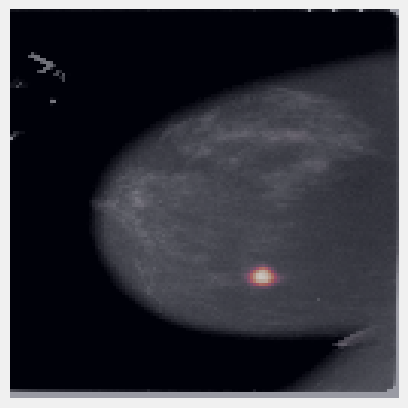

In [40]:
show_mask(image,pred_mask)

In [44]:
pred_mask

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [3],
       [4],
       [6],
    